In [1]:
%matplotlib inline
import os
import re
import io

import matplotlib
import numpy as np
import pandas as pd
import xarray as xr

import climatools.html.html as climahtml
import climatools.lblnew.g1_threshold as scripts

import IPython.display as display

import imp
imp.reload(scripts)

/chia_cluster/home/jackyu/anaconda3/lib/python3.6/site-packages/matplotlib/__init__.py:1405: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


<module 'climatools.lblnew.g1_threshold' from '/chia_cluster/home/jackyu/climatools/climatools/lblnew/g1_threshold.py'>

In [2]:
%run param.py

In [3]:
NG_REFS = PARAM['ng_refs']
P_REFS, T_REFS = zip(*PARAM['ref_pts'])

In [4]:
# for printing some input parameters

def innames():
    return ['vstar', 'nband', 'nv', 'dv',
            'flgh2o',
            'tsfc',
            'pressure_reference_1',
            'temperature_reference_1', 
            'pressure_reference_2', 
            'temperature_reference_2',
            'ighigh', 
            'ng', 
            'nref',
            'p_refs',
            't_refs',
            'ng_refs',
            'ng_adju',
            'absth',
            'wgt',
            'option_wgt_flux',
            'option_wgt_k',
            'option_klin',
            'w_diffuse',
            'fac_meank',
            'klin',
            'option_compute_ktable',
            'option_compute_btable',
            'conc']



def pattern_assign(name):
    return ''' 
    parameter .* :: \s* &? \s* ({} \s* = .* \n)
    '''.format(name)

def pattern_data(name):
    return '''
    (data [^/{name}]+ {name}[^,] [^/{name}]+ / [^/]+ /)
    '''.format(name=name)

def pattern_atmpro():
    return '''
    (atmosphere_profiles/.*75_r8.pro)
    '''
    

def get_input_params(code, names):
    results = []
    for name in names:
        regex = re.compile(pattern_assign(name), re.VERBOSE)
        results.extend(regex.findall(code))
        
        regex = re.compile(pattern_data(name), re.VERBOSE)
        results.extend(regex.findall(code))
        
    regex = re.compile(pattern_atmpro(), re.VERBOSE)
    results.extend(regex.findall(code))
        
    results = [result.replace('_r8', '') for result in results]
    return results


In [5]:
analysis = scripts.Analysis()

In [6]:
crd = analysis.model('crd')
crd.type_model = 'crd'
crd.rundir = DIR_FORTRAN
crd.fpath_flux = 'output_fluxg.dat'
crd.fpath_coolr = 'output_coolrg.dat'
crd.linestyle = '-'
crd.color = 'b'
crd.marker = None
crd.load_data()

In [7]:
def add_wgt_models():
    iggs = [10, 1]
    markers = [None, 'x']
    colors = ['r', 'c']
    linestyle = '-'

    df_wfluxg = pd.read_csv(os.path.join(crd.rundir, 
                                         'output_wfluxg.dat'), 
                            sep=r'\s+')

    df_wcoolrg = pd.read_csv(os.path.join(crd.rundir, 
                                          'output_wcoolrg.dat'), 
                             sep=r'\s+')

    for igg, marker, color in zip(iggs, markers, colors):

        flux_igg = df_wfluxg[df_wfluxg['igg'] == igg]\
        .drop('igg', axis=1)
        s_flux = io.StringIO(flux_igg.to_csv(sep=' '))

        coolr_igg = df_wcoolrg[df_wcoolrg['igg'] == igg]\
        .drop('igg', axis=1)
        s_coolr = io.StringIO(coolr_igg.to_csv(sep=' '))

        crdx_igg = analysis.model('wgt_igg{}'.format(igg))
        crdx_igg.type_model = 'crd'
        crdx_igg.rundir = DIR_FORTRAN
        crdx_igg.fpath_flux = s_flux
        crdx_igg.fpath_coolr = s_coolr
        crdx_igg.color = color
        crdx_igg.marker = marker
        crdx_igg.linestyle = linestyle
        crdx_igg.load_data()
        
add_wgt_models()

In [8]:
def add_ktable_models():
    iggs = [10]
    markers = ['D',]
    color = 'g'
    linestyle = ':'

    df_wwfluxg = pd.read_csv(os.path.join(crd.rundir, 
                                          'output_wwfluxg.dat'), 
                             sep=r'\s+')

    df_wwcoolrg = pd.read_csv(os.path.join(crd.rundir, 
                                           'output_wwcoolrg.dat'), 
                              sep=r'\s+')

    for igg, marker in zip(iggs, markers):

        flux_igg = df_wwfluxg[df_wwfluxg['igg'] == igg]\
        .drop('igg', axis=1)
        s_flux = io.StringIO(flux_igg.to_csv(sep=' '))

        coolr_igg = df_wwcoolrg[df_wwcoolrg['igg'] == igg]\
        .drop('igg', axis=1)
        s_coolr = io.StringIO(coolr_igg.to_csv(sep=' '))

        crdxx_igg = analysis.model('ktable_igg{}'.format(igg))
        crdxx_igg.type_model = 'crd'
        crdxx_igg.rundir = DIR_FORTRAN
        crdxx_igg.fpath_flux = s_flux
        crdxx_igg.fpath_coolr = s_coolr
        crdxx_igg.color = color
        crdxx_igg.marker = marker
        crdxx_igg.linestyle = linestyle
        crdxx_igg.load_data()
        
        

In [9]:
fig = analysis.fig_fluxcoolr('fig1', vartypes=['cooling rate'])
fig.ggroups = list(crd.data['dgdgs'].coords['g'].values) #list(range(1, 8 + 1))
fig.vars_plot['flux'] = ['flug', 'fnetg']
fig.vars_plot['cooling rate'] = ['coolrg']
fig.colors['flug'] = 'darkred'
fig.colors['fnetg'] = 'lightcoral'
fig.colors['coolrg'] = 'blue'
fig.varlims_from_indexrange['linear'] = (50, 1050)
fig.varlims_from_indexrange['log'] = (1e-2, 200)

fig.set_pressure_displayrange(low=1e-2)

In [10]:
table_fluxg = analysis.table('table_fluxg')
table_fluxg.sumg = False
table_fluxg.vartype = 'flux'
table_fluxg.at_pressures = crd.data['flux']\
                             .coords['pressure']\
                             .isel(pressure=[0, -1])

table_coolrg = analysis.table('table_coolrg')
table_coolrg.vartype = 'cooling rate'
table_coolrg.sumg = False
table_coolrg.at_pressures = crd.data['cooling rate']\
                               .coords['pressure']\
                               .isel(pressure=[0, -1])


In [11]:
table_flux = analysis.table('table_flux')
table_flux.sumg = True
table_flux.vartype = 'flux'
table_flux.at_pressures = crd.data['flux']\
                             .coords['pressure']\
                             .isel(pressure=[0, -1])

table_coolr = analysis.table('table_coolr')
table_coolr.vartype = 'cooling rate'
table_coolr.sumg = True
table_coolr.at_pressures = crd.data['cooling rate']\
                              .coords['pressure']\
                              .isel(pressure=[0, -1])

In [12]:
table_dgdgs = analysis.table('dgdgs')
table_dgdgs.vartype = 'dgdgs'
table_dgdgs.sumg = False

In [13]:
for name, value in sorted(PARAM.items()):
    print('{} = {}'.format(name, value))

atmpro = saw
band = 7
commitnumber = e2a721f
conc = 1.8e-06
dv = 0.05
klin = 0
molecule = ch4
ng_adju = [0, 0]
ng_refs = [8, 7]
nv = 20
option_compute_btable = 0
option_compute_ktable = 0
option_wgt_flux = 1
option_wgt_k = 1
ref_pts = [(1, 250), (500, 250)]
tsfc = 257
vmax = 1380
vmin = 1215
w_diffuse = [(1, 1, 1, 1, 1, 1, 1, 1), (1, 1, 1, 1, 1, 1, 1)]
wgt = [(1, 1, 1, 1, 1, 1, 1, 1), (1, 1, 1, 1, 1, 1, 1)]


In [14]:
fig.display_hrefanchor()

In [15]:
table_fluxg.display_hrefanchor()
table_coolrg.display_hrefanchor()

table_flux.display_hrefanchor()
table_coolr.display_hrefanchor()

In [16]:
table_dgdgs.display_hrefanchor()

In [17]:
s_abscom = 'Overall absth'
display.HTML(climahtml.getHTML_hrefanchor(s_abscom))

In [18]:
s_ggroup_summary = 'g-group summary'
display.HTML(climahtml.getHTML_hrefanchor(s_ggroup_summary))

In [19]:
#for g in range(1, 20 + 1):
#    s = 'Table: cooling rate. g-group {}'.format(g)
#    html = climahtml.getHTML_hrefanchor(s)
#    display.display(display.HTML(html))

# Figure: cooling rate g-group 1

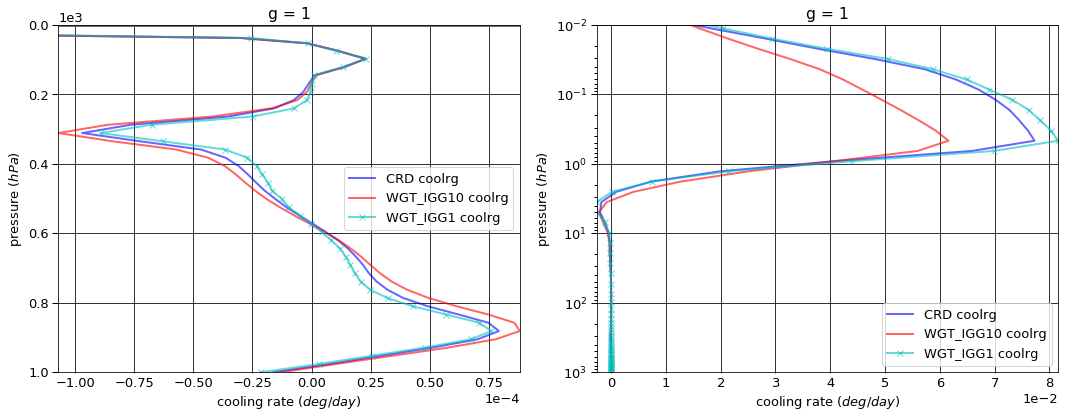

# Figure: cooling rate g-group 2

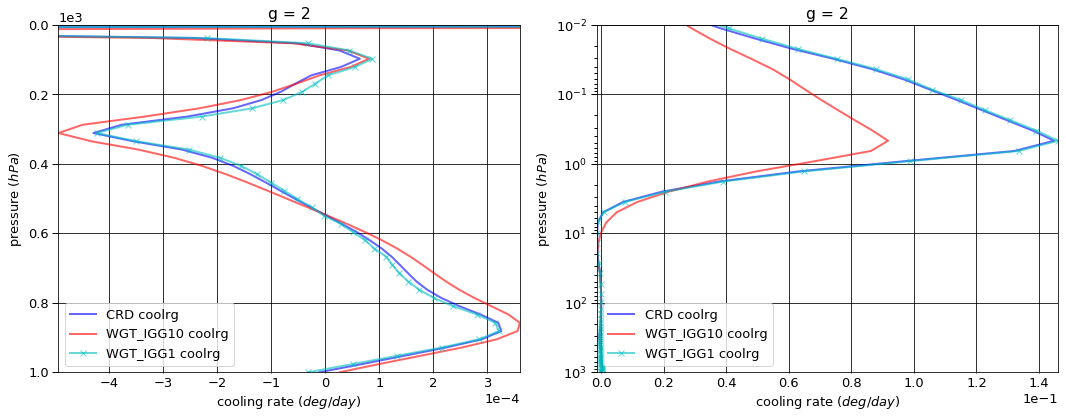

# Figure: cooling rate g-group 3

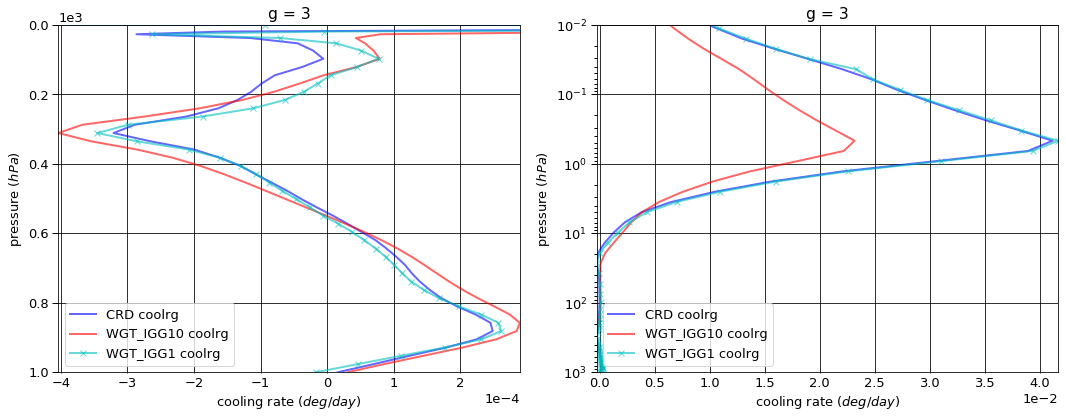

# Figure: cooling rate g-group 4

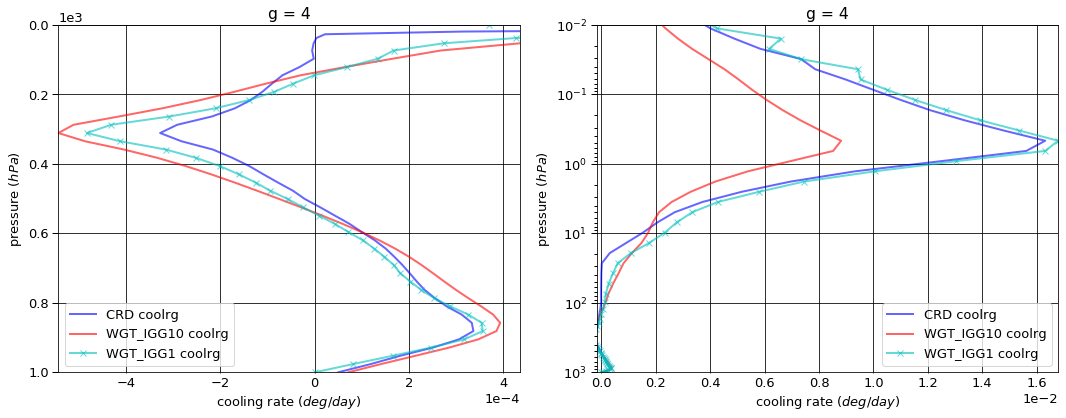

# Figure: cooling rate g-group 5

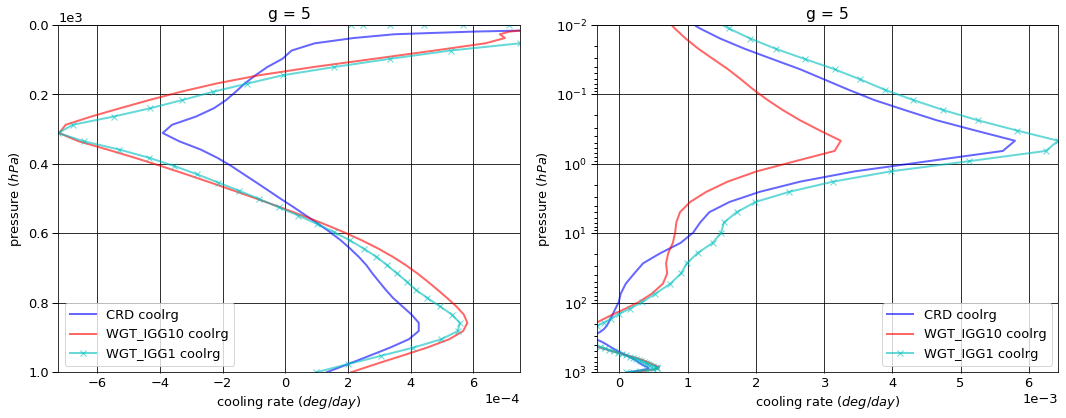

# Figure: cooling rate g-group 6

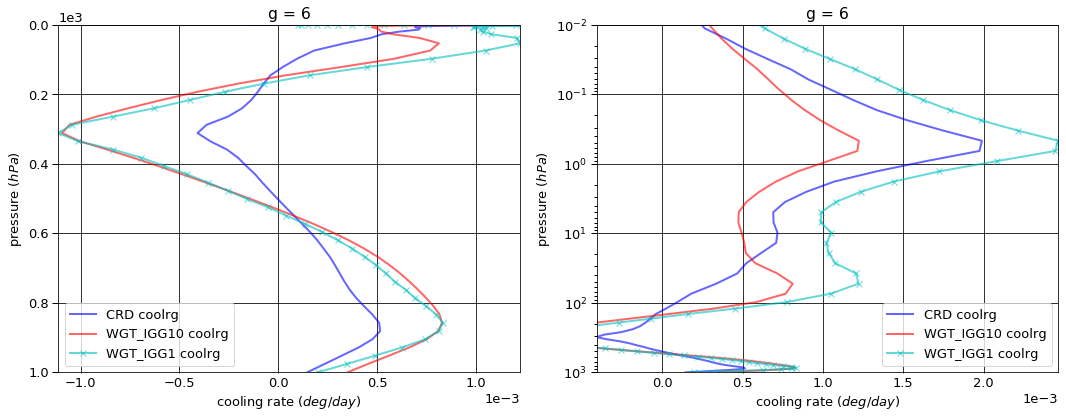

# Figure: cooling rate g-group 7

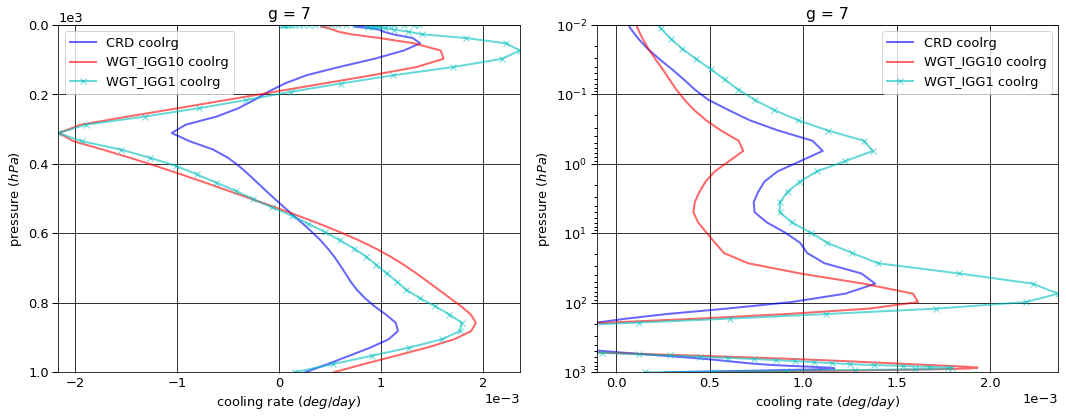

# Figure: cooling rate g-group 8

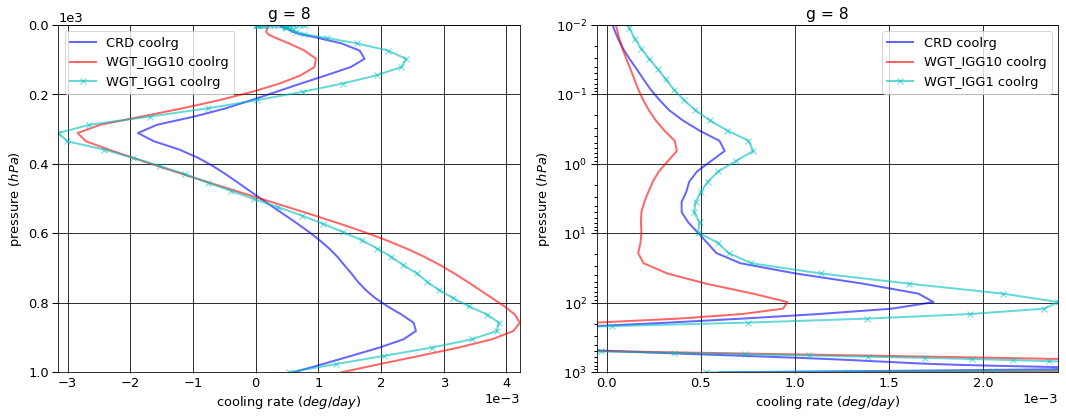

# Figure: cooling rate g-group 9

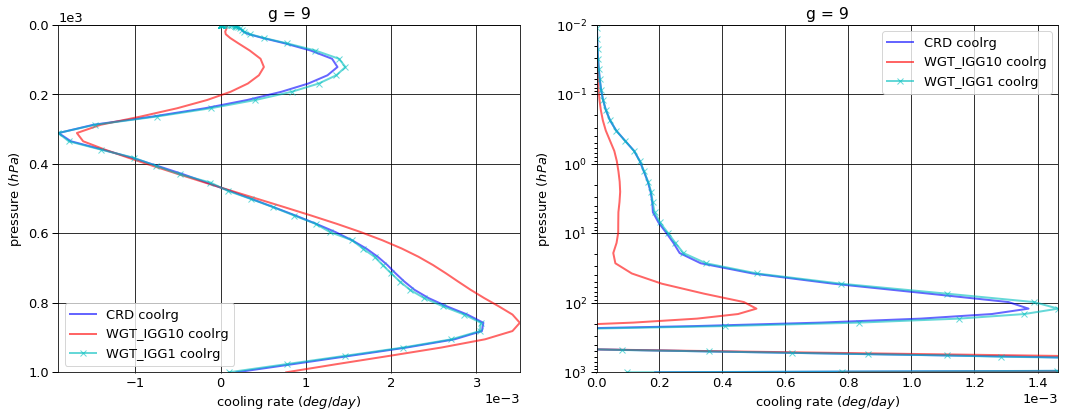

# Figure: cooling rate g-group 10

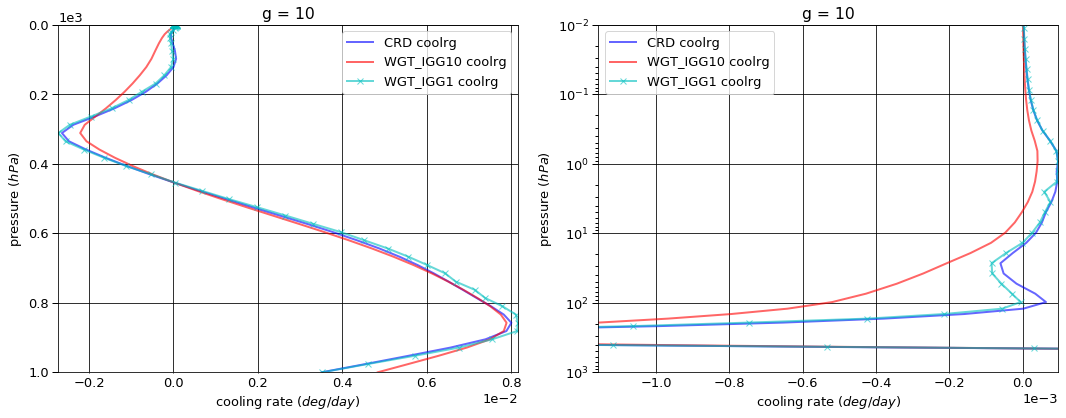

# Figure: cooling rate g-group 11

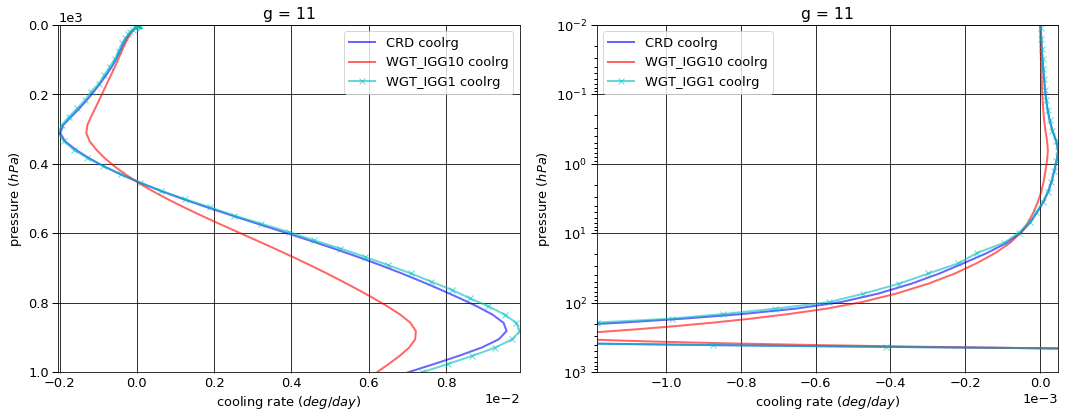

# Figure: cooling rate g-group 12

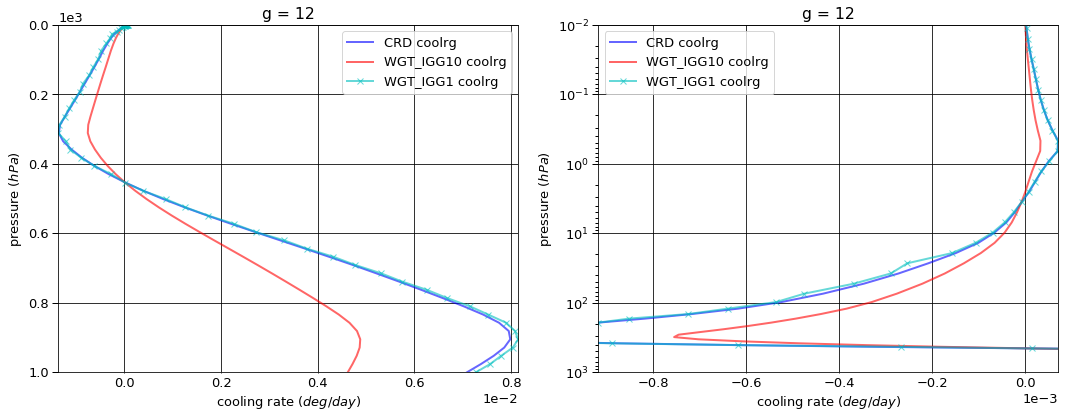

# Figure: cooling rate g-group 13

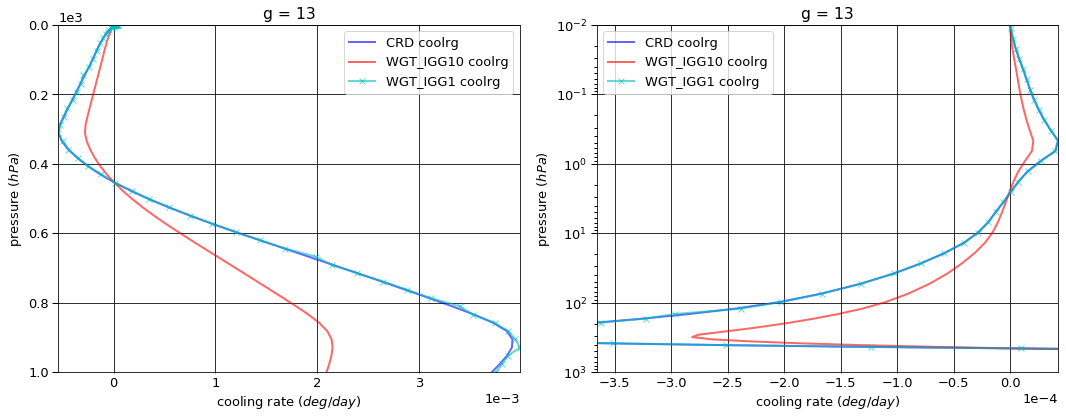

# Figure: cooling rate g-group 14

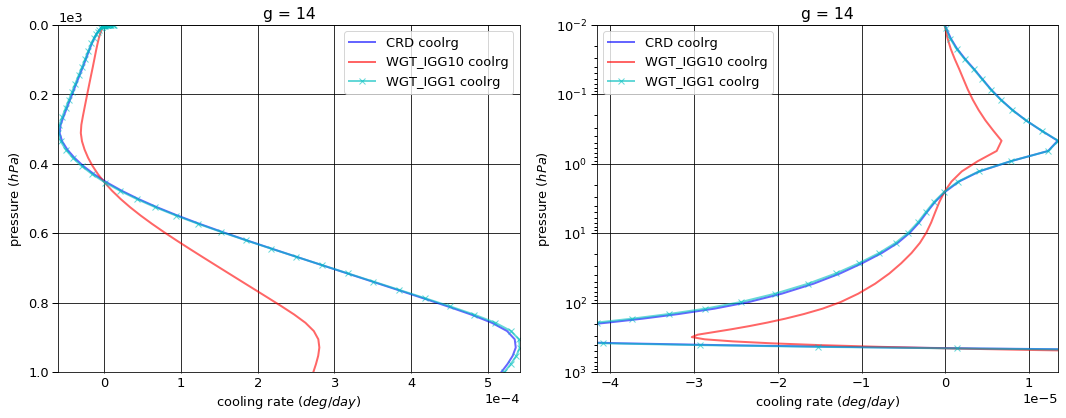

# Figure: cooling rate g-group 15

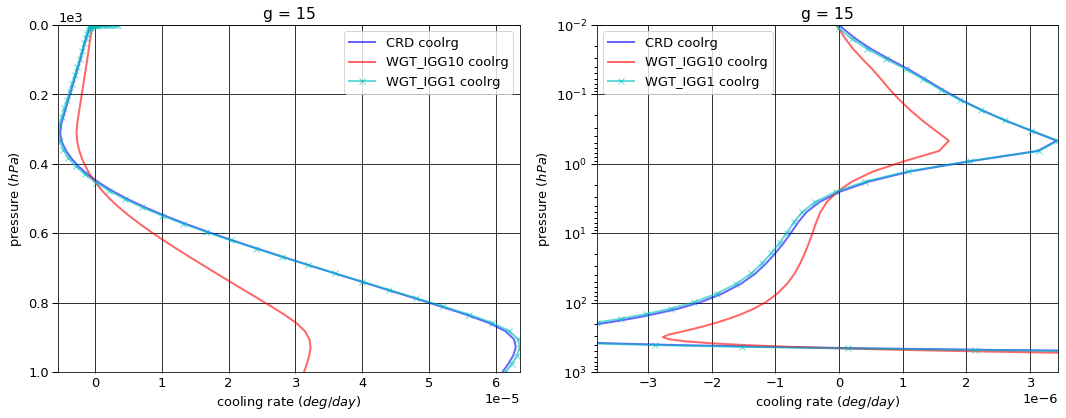

# Figure: cooling rate g-group total

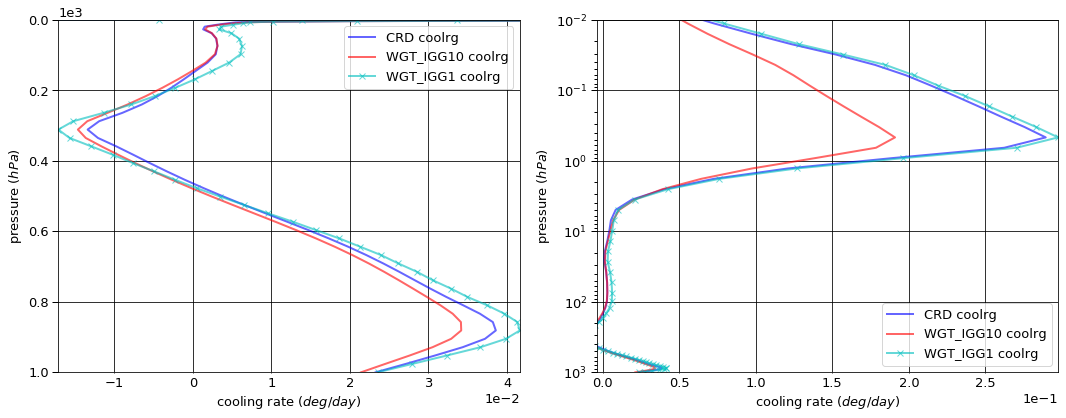

In [20]:
matplotlib.rcParams.update({'font.size': 13,
                            'grid.color': 'black',
                            'axes.facecolor': 'white',
                            'axes.edgecolor': 'black',
                            'ytick.direction': 'out',
                            'ytick.major.size': 6, 'ytick.major.width': 1,
                            'ytick.minor.size': 3, 'ytick.minor.width': 1,
                            'xtick.direction': 'out',
                            'xtick.major.size': 6, 'xtick.major.size': 1,
                            'xtick.minor.size': 3, 'xtick.minor.size': 1}) 

fig.plot(analysis)


In [21]:
table_fluxg.display_withdiff(analysis, benchmark='crd')
table_coolrg.display_withdiff(analysis, benchmark='crd')
table_flux.display_withdiff(analysis, benchmark='crd')
table_coolr.display_withdiff(analysis, benchmark='crd')

# Table: flux. g-groups 


CRD


flug      fldg     fnetg
g  pressure level                              
1  0.0      1     -0.007859  0.000000 -0.007859
   1013.0   76    -0.010670  0.010892  0.000222
2  0.0      1     -0.021164  0.000000 -0.021164
   1013.0   76    -0.038687  0.038975  0.000289
3  0.0      1     -0.011812  0.000000 -0.011812
   1013.0   76    -0.031317  0.029582 -0.001736
4  0.0      1     -0.015096  0.000000 -0.015096
   1013.0   76    -0.040601  0.035664 -0.004936
5  0.0      1     -0.026517  0.000000 -0.026517
   1013.0   76    -0.058551  0.042590 -0.015961
6  0.0      1     -0.053620  0.000000 -0.053620
   1013.0   76    -0.088816  0.049905 -0.038910
7  0.0      1     -0.111890  0.000000 -0.111890
   1013.0   76    -0.195176  0.120283 -0.074893
8  0.0      1     -0.233699  0.000000 -0.233699
   1013.0   76    -0.397547  0.249105 -0.148442
9  0.0      1     -0.107730  0.000000 -0.107730
   1013.0   76    -0.316891  0.315952 -0.000939
10 0.0      1     -0.409090  0.000000 -0.409090
   1013.0   76    -0.706193  0.581193 -0.125000
11 0.0      1     -0.970452  0.000000 -0.970452
   1013.0   76    -1.175423  0.554365 -0.621058
12 0.0      1     -2.099421  0.000000 -2.099421
   1013.0   76    -2.230010  0.417702 -1.812308
13 0.0      1     -2.739202  0.000000 -2.739202
   1013.0   76    -2.790597  0.191931 -2.598666
14 0.0      1     -1.096280  0.000000 -1.096280
   1013.0   76    -1.102107  0.025174 -1.076934
15 0.0      1     -0.374876  0.000000 -0.374876
   1013.0   76    -0.375445  0.002845 -0.372600


WGT_IGG10


flug      fldg     fnetg
g  pressure level                              
1  0.0      1     -0.007380  0.000000 -0.007380
   1013.0   76    -0.010623  0.010913  0.000290
2  0.0      1     -0.017943  0.000000 -0.017943
   1013.0   76    -0.038587  0.038940  0.000353
3  0.0      1     -0.009875  0.000000 -0.009875
   1013.0   76    -0.031292  0.031395  0.000103
4  0.0      1     -0.010613  0.000000 -0.010613
   1013.0   76    -0.040463  0.039956 -0.000507
5  0.0      1     -0.015680  0.000000 -0.015680
   1013.0   76    -0.058577  0.053887 -0.004690
6  0.0      1     -0.024884  0.000000 -0.024884
   1013.0   76    -0.088756  0.078077 -0.010679
7  0.0      1     -0.055021  0.000000 -0.055021
   1013.0   76    -0.195024  0.186762 -0.008261
8  0.0      1     -0.145310  0.000000 -0.145310
   1013.0   76    -0.397107  0.372704 -0.024403
9  0.0      1     -0.123442  0.000000 -0.123442
   1013.0   76    -0.316278  0.309457 -0.006821
10 0.0      1     -0.477690  0.000000 -0.477690
   1013.0   76    -0.705061  0.509123 -0.195938
11 0.0      1     -1.049222  0.000000 -1.049222
   1013.0   76    -1.174747  0.388575 -0.786172
12 0.0      1     -2.157411  0.000000 -2.157411
   1013.0   76    -2.228392  0.244961 -1.983431
13 0.0      1     -2.763311  0.000000 -2.763311
   1013.0   76    -2.789731  0.102961 -2.686770
14 0.0      1     -1.102768  0.000000 -1.102768
   1013.0   76    -1.105758  0.012969 -1.092790
15 0.0      1     -0.377343  0.000000 -0.377343
   1013.0   76    -0.377635  0.001443 -0.376192


WGT_IGG1


flug      fldg     fnetg
g  pressure level                              
1  0.0      1     -0.008158  0.000000 -0.008158
   1013.0   76    -0.010623  0.010893  0.000270
2  0.0      1     -0.021502  0.000000 -0.021502
   1013.0   76    -0.038587  0.039408  0.000821
3  0.0      1     -0.011567  0.000000 -0.011567
   1013.0   76    -0.031292  0.031894  0.000601
4  0.0      1     -0.011419  0.000000 -0.011419
   1013.0   76    -0.040463  0.040956  0.000493
5  0.0      1     -0.015189  0.000000 -0.015189
   1013.0   76    -0.058577  0.057217 -0.001360
6  0.0      1     -0.023121  0.000000 -0.023121
   1013.0   76    -0.088756  0.084501 -0.004254
7  0.0      1     -0.051237  0.000000 -0.051237
   1013.0   76    -0.195024  0.194524 -0.000500
8  0.0      1     -0.123325  0.000000 -0.123325
   1013.0   76    -0.397107  0.392411 -0.004696
9  0.0      1     -0.103795  0.000000 -0.103795
   1013.0   76    -0.316278  0.318989  0.002711
10 0.0      1     -0.396549  0.000000 -0.396549
   1013.0   76    -0.705061  0.601020 -0.104041
11 0.0      1     -0.965532  0.000000 -0.965532
   1013.0   76    -1.174747  0.571345 -0.603402
12 0.0      1     -2.096631  0.000000 -2.096631
   1013.0   76    -2.228392  0.424447 -1.803945
13 0.0      1     -2.738407  0.000000 -2.738407
   1013.0   76    -2.789731  0.193106 -2.596625
14 0.0      1     -1.099844  0.000000 -1.099844
   1013.0   76    -1.105758  0.025274 -1.080484
15 0.0      1     -0.377054  0.000000 -0.377054
   1013.0   76    -0.377635  0.002852 -0.374783


WGT_IGG10 - CRD


flug      fldg     fnetg
g  pressure level                              
1  0.0      1      0.000479  0.000000  0.000479
   1013.0   76     0.000047  0.000021  0.000068
2  0.0      1      0.003221  0.000000  0.003221
   1013.0   76     0.000100 -0.000036  0.000064
3  0.0      1      0.001937  0.000000  0.001937
   1013.0   76     0.000025  0.001814  0.001839
4  0.0      1      0.004483  0.000000  0.004483
   1013.0   76     0.000137  0.004292  0.004429
5  0.0      1      0.010837  0.000000  0.010837
   1013.0   76    -0.000026  0.011297  0.011271
6  0.0      1      0.028736  0.000000  0.028736
   1013.0   76     0.000060  0.028172  0.028232
7  0.0      1      0.056869  0.000000  0.056869
   1013.0   76     0.000152  0.066479  0.066631
8  0.0      1      0.088389  0.000000  0.088389
   1013.0   76     0.000441  0.123599  0.124039
9  0.0      1     -0.015712  0.000000 -0.015712
   1013.0   76     0.000614 -0.006495 -0.005881
10 0.0      1     -0.068600  0.000000 -0.068600
   1013.0   76     0.001132 -0.072070 -0.070938
11 0.0      1     -0.078770  0.000000 -0.078770
   1013.0   76     0.000676 -0.165790 -0.165114
12 0.0      1     -0.057989  0.000000 -0.057989
   1013.0   76     0.001618 -0.172741 -0.171123
13 0.0      1     -0.024110  0.000000 -0.024110
   1013.0   76     0.000866 -0.088970 -0.088104
14 0.0      1     -0.006489  0.000000 -0.006489
   1013.0   76    -0.003651 -0.012205 -0.015856
15 0.0      1     -0.002467  0.000000 -0.002467
   1013.0   76    -0.002190 -0.001402 -0.003592


WGT_IGG1 - CRD


flug      fldg     fnetg
g  pressure level                              
1  0.0      1     -0.000299  0.000000 -0.000299
   1013.0   76     0.000047  0.000001  0.000048
2  0.0      1     -0.000338  0.000000 -0.000338
   1013.0   76     0.000100  0.000433  0.000533
3  0.0      1      0.000246  0.000000  0.000246
   1013.0   76     0.000025  0.002312  0.002337
4  0.0      1      0.003677  0.000000  0.003677
   1013.0   76     0.000137  0.005292  0.005429
5  0.0      1      0.011328  0.000000  0.011328
   1013.0   76    -0.000026  0.014626  0.014601
6  0.0      1      0.030498  0.000000  0.030498
   1013.0   76     0.000060  0.034596  0.034656
7  0.0      1      0.060653  0.000000  0.060653
   1013.0   76     0.000152  0.074240  0.074392
8  0.0      1      0.110373  0.000000  0.110373
   1013.0   76     0.000441  0.143306  0.143747
9  0.0      1      0.003935  0.000000  0.003935
   1013.0   76     0.000614  0.003037  0.003651
10 0.0      1      0.012542  0.000000  0.012542
   1013.0   76     0.001132  0.019827  0.020959
11 0.0      1      0.004920  0.000000  0.004920
   1013.0   76     0.000676  0.016980  0.017656
12 0.0      1      0.002790  0.000000  0.002790
   1013.0   76     0.001618  0.006746  0.008364
13 0.0      1      0.000795  0.000000  0.000795
   1013.0   76     0.000866  0.001175  0.002041
14 0.0      1     -0.003565  0.000000 -0.003565
   1013.0   76    -0.003651  0.000101 -0.003550
15 0.0      1     -0.002178  0.000000 -0.002178
   1013.0   76    -0.002190  0.000008 -0.002183

# Table: cooling rate. g-groups 


CRD


coolrg
g  pressure    layer              
1  0.000312    1     -4.479054e-02
   1001.112500 75    -1.625136e-05
2  0.000312    1     -2.029282e-02
   1001.112500 75    -1.147122e-05
3  0.000312    1     -5.717792e-04
   1001.112500 75     1.576236e-05
4  0.000312    1     -5.843563e-05
   1001.112500 75     4.972892e-05
5  0.000312    1     -5.344304e-05
   1001.112500 75     1.314207e-04
6  0.000312    1     -1.472716e-04
   1001.112500 75     1.464250e-04
7  0.000312    1     -6.534120e-05
   1001.112500 75     2.588718e-04
8  0.000312    1     -3.220658e-05
   1001.112500 75     6.012062e-04
9  0.000312    1      9.565412e-08
   1001.112500 75     1.867896e-04
10 0.000312    1     -4.516476e-07
   1001.112500 75     3.509486e-03
11 0.000312    1     -1.632360e-06
   1001.112500 75     7.016833e-03
12 0.000312    1     -5.266589e-06
   1001.112500 75     7.089629e-03
13 0.000312    1     -4.848159e-06
   1001.112500 75     3.712976e-03
14 0.000312    1     -1.102024e-06
   1001.112500 75     5.171368e-04
15 0.000312    1     -6.415888e-07
   1001.112500 75     6.099217e-05


WGT_IGG10


coolrg
g  pressure    layer              
1  0.000312    1     -1.619890e-02
   1001.112500 75    -1.305763e-05
2  0.000312    1     -2.326697e-03
   1001.112500 75     2.633997e-05
3  0.000312    1      7.472010e-04
   1001.112500 75     3.059627e-05
4  0.000312    1      3.325404e-04
   1001.112500 75     7.134690e-05
5  0.000312    1      1.089788e-04
   1001.112500 75     2.092418e-04
6  0.000312    1      4.335944e-05
   1001.112500 75     3.507209e-04
7  0.000312    1      1.285062e-05
   1001.112500 75     5.350465e-04
8  0.000312    1      2.416104e-06
   1001.112500 75     1.368710e-03
9  0.000312    1      1.515222e-08
   1001.112500 75     7.703244e-04
10 0.000312    1     -3.938246e-07
   1001.112500 75     4.838299e-03
11 0.000312    1     -1.173157e-06
   1001.112500 75     6.211175e-03
12 0.000312    1     -3.121975e-06
   1001.112500 75     4.623274e-03
13 0.000312    1     -2.572020e-06
   1001.112500 75     2.090783e-03
14 0.000312    1     -5.781355e-07
   1001.112500 75     2.724537e-04
15 0.000312    1     -3.558346e-07
   1001.112500 75     3.127713e-05


WGT_IGG1


coolrg
g  pressure    layer              
1  0.000312    1     -4.313423e-02
   1001.112500 75    -2.153119e-05
2  0.000312    1     -2.090354e-02
   1001.112500 75    -3.217104e-05
3  0.000312    1     -4.172163e-04
   1001.112500 75    -1.719171e-05
4  0.000312    1      3.696421e-04
   1001.112500 75     6.616639e-07
5  0.000312    1      2.083763e-04
   1001.112500 75     9.852666e-05
6  0.000312    1      9.972587e-05
   1001.112500 75     1.998661e-04
7  0.000312    1      3.032808e-05
   1001.112500 75     1.533057e-04
8  0.000312    1      1.204039e-05
   1001.112500 75     5.305561e-04
9  0.000312    1      1.260993e-07
   1001.112500 75     9.774866e-05
10 0.000312    1     -1.922895e-07
   1001.112500 75     3.527176e-03
11 0.000312    1     -1.533809e-06
   1001.112500 75     7.383385e-03
12 0.000312    1     -5.192877e-06
   1001.112500 75     7.273473e-03
13 0.000312    1     -4.801237e-06
   1001.112500 75     3.754676e-03
14 0.000312    1     -1.132048e-06
   1001.112500 75     5.210795e-04
15 0.000312    1     -7.048770e-07
   1001.112500 75     6.146290e-05


WGT_IGG10 - CRD


coolrg
g  pressure    layer              
1  0.000312    1      2.859165e-02
   1001.112500 75     3.193731e-06
2  0.000312    1      1.796612e-02
   1001.112500 75     3.781119e-05
3  0.000312    1      1.318980e-03
   1001.112500 75     1.483391e-05
4  0.000312    1      3.909760e-04
   1001.112500 75     2.161798e-05
5  0.000312    1      1.624218e-04
   1001.112500 75     7.782113e-05
6  0.000312    1      1.906310e-04
   1001.112500 75     2.042959e-04
7  0.000312    1      7.819182e-05
   1001.112500 75     2.761747e-04
8  0.000312    1      3.462269e-05
   1001.112500 75     7.675034e-04
9  0.000312    1     -8.050190e-08
   1001.112500 75     5.835348e-04
10 0.000312    1      5.782300e-08
   1001.112500 75     1.328812e-03
11 0.000312    1      4.592022e-07
   1001.112500 75    -8.056575e-04
12 0.000312    1      2.144614e-06
   1001.112500 75    -2.466355e-03
13 0.000312    1      2.276139e-06
   1001.112500 75    -1.622192e-03
14 0.000312    1      5.238886e-07
   1001.112500 75    -2.446831e-04
15 0.000312    1      2.857542e-07
   1001.112500 75    -2.971504e-05


WGT_IGG1 - CRD


coolrg
g  pressure    layer              
1  0.000312    1      1.656316e-03
   1001.112500 75    -5.279821e-06
2  0.000312    1     -6.107230e-04
   1001.112500 75    -2.069983e-05
3  0.000312    1      1.545629e-04
   1001.112500 75    -3.295408e-05
4  0.000312    1      4.280778e-04
   1001.112500 75    -4.906725e-05
5  0.000312    1      2.618193e-04
   1001.112500 75    -3.289399e-05
6  0.000312    1      2.469974e-04
   1001.112500 75     5.344110e-05
7  0.000312    1      9.566928e-05
   1001.112500 75    -1.055661e-04
8  0.000312    1      4.424697e-05
   1001.112500 75    -7.065012e-05
9  0.000312    1      3.044517e-08
   1001.112500 75    -8.904097e-05
10 0.000312    1      2.593581e-07
   1001.112500 75     1.768990e-05
11 0.000312    1      9.855090e-08
   1001.112500 75     3.665522e-04
12 0.000312    1      7.371200e-08
   1001.112500 75     1.838446e-04
13 0.000312    1      4.692190e-08
   1001.112500 75     4.169990e-05
14 0.000312    1     -3.002340e-08
   1001.112500 75     3.942630e-06
15 0.000312    1     -6.328821e-08
   1001.112500 75     4.707330e-07

# Table: flux. g-groups total


CRD


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,-8.278708,0.000000,-8.278708
1013.0,76,-9.558030,2.666157,-6.891873



WGT_IGG10


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,-8.337893,0.000000,-8.337893
1013.0,76,-9.558030,2.382123,-7.175907



WGT_IGG1


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,-8.043331,0.000000,-8.043331
1013.0,76,-9.558030,2.988837,-6.569193



WGT_IGG10 - CRD


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,-5.918420e-02,0.000000,-0.059184
1013.0,76,5.200000e-08,-0.284034,-0.284034



WGT_IGG1 - CRD


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,2.353771e-01,0.00000,0.235377
1013.0,76,5.200000e-08,0.32268,0.322680


# Table: cooling rate. g-groups total


CRD


,,coolrg
pressure,layer,
0.000312,1,-0.066026
1001.112500,75,0.023270



WGT_IGG10


,,coolrg
pressure,layer,
0.000312,1,-0.017286
1001.112500,75,0.021417



WGT_IGG1


,,coolrg
pressure,layer,
0.000312,1,-0.063748
1001.112500,75,0.023531



WGT_IGG10 - CRD


,,coolrg
pressure,layer,
0.000312,1,0.048739
1001.112500,75,-0.001853



WGT_IGG1 - CRD


,,coolrg
pressure,layer,
0.000312,1,0.002277
1001.112500,75,0.000261


In [22]:
table_dgdgs.display_dgdgs(crd)

# Table: dgdgs. g-groups 

,dg,dgs
g,,
1,0.001212,0.001111
2,0.004242,0.004037
3,0.003333,0.003274
4,0.004545,0.004233
5,0.006061,0.006129
6,0.009394,0.009286
7,0.020606,0.020404
8,0.042424,0.041547
9,0.034242,0.033090


In [23]:
# read and display overall absth
display.display(
    display.HTML(climahtml.getHTML_idanchor(s_abscom)))
display.display(
    display.Markdown(climahtml.getMarkdown_sectitle(s_abscom)))

display.display(pd.read_csv(os.path.join(crd.rundir, 'abscom.dat'),
                sep=r'\s+',
                index_col=[0]))

# Overall absth

,abscom
g,
1,7.764177e-18
2,2.153649e-18
3,5.973852e-19
4,1.657044e-19
5,4.596354e-20
6,1.274950e-20
7,3.536491e-21
8,9.809617e-22
9,9.486845e-20


In [24]:
def spreadsheet(ng_refs, p_refs):
    ng = crd.data['dgdgs'].dims['g']
    
    df_abscom = pd.read_csv(os.path.join(crd.rundir, 'abscom.dat'), 
                            sep=r'\s+', index_col=[0])
    
    # absth(g + 1) / absth(g)
    df_abscom_copy = df_abscom.copy()
    df_abscom_copy.index = df_abscom.index + 1
    df_absratio = df_abscom / df_abscom_copy
    df_absratio.columns = ['k(ig) / k(ig - 1)']
    df_absratio = df_absratio.loc[: ng]
    df_dgdgs = crd.data['dgdgs'].to_dataframe()
    
    
    df_dgdgs_cumsum = df_dgdgs.cumsum(axis=0)
    df_dgdgs_cumsum.columns = ['dg cumsum', 'dgs cumsum']
    
    data_pref = np.concatenate([p_ref * np.ones((ng_ref,)) 
                                for ng_ref, p_ref 
                                in zip(ng_refs, p_refs)], axis=0)
    df_pref = pd.DataFrame(data_pref, 
                           index=df_dgdgs.index, columns=['pref'])
    
    df_all = pd.concat([df_abscom, df_absratio,
                        df_dgdgs, df_dgdgs_cumsum,
                        df_pref], axis=1) 
    return df_all
    

In [25]:
display.display(display.HTML(climahtml.getHTML_idanchor(s_ggroup_summary)))
display.display(display.Markdown(climahtml.getMarkdown_sectitle(s_ggroup_summary)))
display.display(spreadsheet(NG_REFS, P_REFS))

# g-group summary

,abscom,k(ig) / k(ig - 1),dg,dgs,dg cumsum,dgs cumsum,pref
g,,,,,,,
1,7.764177e-18,NaN,0.001212,0.001111,0.001212,0.001111,1.0
2,2.153649e-18,0.277383,0.004242,0.004037,0.005455,0.005149,1.0
3,5.973852e-19,0.277383,0.003333,0.003274,0.008788,0.008422,1.0
4,1.657044e-19,0.277383,0.004545,0.004233,0.013333,0.012656,1.0
5,4.596354e-20,0.277383,0.006061,0.006129,0.019394,0.018784,1.0
6,1.274950e-20,0.277383,0.009394,0.009286,0.028788,0.028070,1.0
7,3.536491e-21,0.277383,0.020606,0.020404,0.049394,0.048475,1.0
8,9.809617e-22,0.277383,0.042424,0.041547,0.091818,0.090022,1.0
9,9.486845e-20,96.709632,0.034242,0.033090,0.126061,0.123112,500.0


In [26]:
def load_d_bigsum():
    
    ng = 10
    
    fpath = os.path.join(crd.rundir, 'd_bigsum.dat')
    df = pd.read_csv(fpath, sep=r'\s+', index_col = [0, 1])

    g_layers = [(1, 62), (2, 58)]
    
    writer = pd.ExcelWriter('_'.join(['d_bigsum_absgas',
                                      'ng_{}'.format(ng)])
                            + '.xlsx')
    for g, layer in g_layers:
        df.loc[(g, layer), :].to_excel(writer, 
                                       '({}, {})'.format(g, layer))
        

#load_d_bigsum()

In [27]:
display.HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')
